In [42]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from scipy import stats
%matplotlib inline

In [2]:
xr.__version__

'0.16.2'

In [27]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
ncores = 10
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='2:30:00')
cluster.scale(ncores)
client = Client(cluster)

In [40]:
# note that the extra workers can get stuck in the queue
#   rerun this cell until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.200:38036 Dashboard: http://10.12.205.200:34963/status,Cluster Workers: 10 Cores: 10 Memory: 104.00 GB


### Some useful functions
 - run each of these cells, before data I/O and analysis
 - should not need to edit these

In [19]:
def get_file(ee,model,field,yr):
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [21]:
def all_files(model,field,firstyear):
    if model == 'CESM1':
        nens = 42
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    else:
        nens = 50
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [22]:
def get_monthly(fields,model,firstyear):
    """ retrieve monthly data from CESM LENS1 or LENS2 using xarray

    Keyword arguments:
    fields    -- list of required variables
    model     -- 'CESM1' or 'CESM2'
    firstyear -- first year required for analysis
    
    Notes:
      * you don't need to ask for lat,lon,area,landfrac,etc
      * you must be on casper for this to work (not cheyenne)
      * each 1d variable is ~1.3GB/decade, consider taking only what you need :)
    """
    #set up an ensemble dimension
    files = all_files(model,fields[0],firstyear)
    ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
    ensdim.attrs['long_name']='ensemble number'
    firstvar = True
    concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
    
    #read the data
    for field in fields:
        #firstvar to instantiate ds, avoid duplicating area,landfrac
        if firstvar:    
            firstvar = False
            paths = files[0]
            ds = xr.open_mfdataset(paths,combine='by_coords')
        #main data read
        files = all_files(model,field,firstyear)
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            ds_temp= xr.open_mfdataset(files,combine='nested',parallel=True,
                                   concat_dim=concat_dim[model])
        #copy to ds
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            ds[field]=ds_temp[field]

    #fix time dimension
    yr0 = ds['time.year'][0].values
    nmonths = len(ds.time)
    ds['time']=xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    
    #return subsetted ds
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        return ds.isel(time=ds['time.year']>=firstyear)

In [23]:
def load_x(x,niters):
    """ loads an xarray calculation, allowing for partial serialization

    Keyword arguments:
    x      -- the calculation
    niters -- first year required for analysis
    
    Notes:
      * useful if your calculation is spilling onto disk
      * the data are chunked by ensemble member
    
    Example:
      x = ds.NBP.mean(dim='time')
      load_x(x,5)    #splits the calculation into 5 steps
    """
    nens = len(x['ens'])
    niters = min(nens,niters)
    cutvals = np.linspace(0,nens,niters+1)
    for ee1,ee2 in zip(cutvals[1:],cutvals[:-1]):
        ix = np.logical_and(x['ens']>=ee1,x['ens']<ee2)
        x.isel(ens=ix).load()
        

In [24]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [25]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:

### Reading the data in:

In [43]:
%%time
data_vars = ['NBP','TWS']
firstyear = 2000
ds = get_monthly(data_vars,'CESM2',firstyear)

CPU times: user 7.57 s, sys: 1.92 s, total: 9.49 s
Wall time: 12.8 s


## Sample analyses

In [44]:
ds.NBP

,Array,Chunk
Bytes,1.99 GB,26.54 MB
Shape,"(50, 180, 192, 288)","(1, 120, 192, 288)"
Count,500 Tasks,100 Chunks
Type,float32,numpy.ndarray


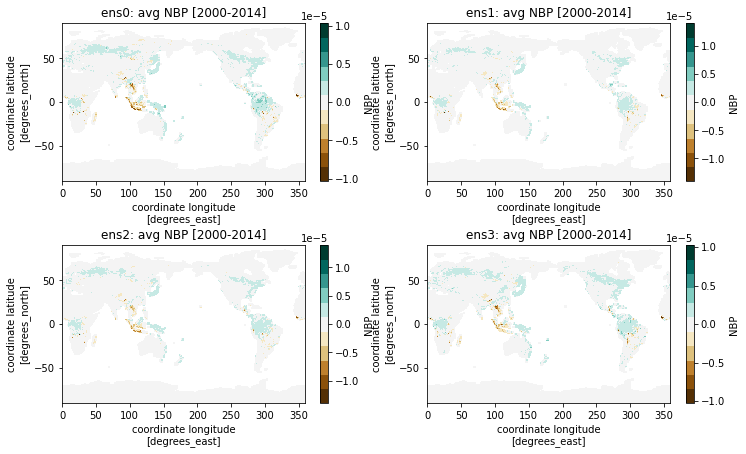

In [45]:
plt.figure(figsize=[12,7])
for ee in range(4):
    plt.subplot(2,2,ee+1)
    ds.NBP.sel(ens=ee).mean(dim='time').plot(cmap=ccc)
    plt.title('ens'+str(ee)+': avg NBP [2000-2014]');
plt.subplots_adjust(hspace=0.4)

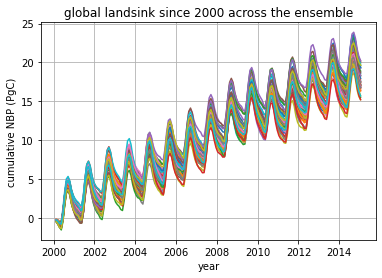

In [78]:
landarea = ds['area']*ds['landfrac']
nyears   = len(np.unique(ds['time.year']))
xf       = 24*60*60*1e-9

monthly_nbp = xf*month_wts(nyears)*(landarea*ds.NBP).sum(dim=['lat','lon']) #PgC
cumsum      = monthly_nbp.cumsum(dim='time')

t = ds['time.year']+1/24+ds['time.month']/12
plt.plot(t,cumsum)
plt.grid()
plt.ylabel('cumulative NBP (PgC)');
plt.xlabel('year')
plt.title('global landsink since 2000 across the ensemble');

### Watch out for overloading memory
 - calculation will spill onto disk
 - you'll generate files like core-casper03-24189-243804-11
 - will slow down the calculation
 - and will clog your directory

### Example:

In [75]:
%%time
x = ds[data_vars].mean(dim='time')
x.load()


y=4 #dummy expression to suppress output

CPU times: user 2.06 s, sys: 242 ms, total: 2.3 s
Wall time: 9.37 s


### Quick fix with load_x:
 - not necessarily faster, but avoids the data spills
 - very finicky to get the niters correct
 - hopeful to find an alternative solution

In [71]:
%%time
x = ds[data_vars].mean(dim='time')
load_x(x,5)  #splitting the calculation into 5 pieces
x.load()


y=4 #dummy expression to suppress output

CPU times: user 1.76 s, sys: 178 ms, total: 1.94 s
Wall time: 8.87 s
